In [64]:
# параметры робота
# улавливает расстояния от 0 до 9.5 метров 
# # адекватнее: от 0.5 = это расстояние от центра до края (кстати, когда расстояние РАВНО 0.5, это плохо, потому что мы врезались)
# угол обзора лидара 360 градусов

In [65]:
# входы
# угол м-у осью робота и препятствием (alpha) (градусы)
# расстояние между центром робота и препятствием (s) (м)
# скорость робота (линейная) (v) (м/c)

# в первую очередь судить по alpha
# если s <= 0.5, то мы УЖЕ врезались

In [103]:
from fuzzylogic.classes import Domain
from fuzzylogic.functions import gauss, bounded_sigmoid, S, trapezoid, R, triangular

# domains
alpha = Domain("Angle between the robot and an obstacle (degree)", 0, 360)
s = Domain("Distance between the robot and an obstacle (cm)", 50, 950)
v = Domain("Current linear speed of the robot (cm/s)", 0, 1000)

# sets = сделать категории и присвоить им функции принадлежности (NB: моё понимание может быть некорректным)

# alpha
# [0; 30] высокий риск врезаться (препятствие справа)
# [30; 90] средний риск врезаться
# [90; 315] маленький шанс врезаться
# [315; 360] высокий риск врезаться (препятствие слева)

alpha.high_risk_right = bounded_sigmoid(30, 45, inverse=True)
# чтобы максимум доходил до 1
alpha.high_risk_right = alpha.high_risk_right.normalized()

alpha.medium_risk = gauss(70, 0.005, c_m=1)

alpha.low_risk_left = bounded_sigmoid(110, 130, inverse=False)
alpha.low_risk_right = bounded_sigmoid(220, 260, inverse=True)
alpha.low_risk = alpha.low_risk_left & alpha.low_risk_right

alpha.high_risk_left = bounded_sigmoid(280, 310, inverse=False)
alpha.high_risk_left = alpha.high_risk_left.normalized()

# s (в см)
# опасно близко (для поворота пространства нет) [50; 75]
# близко (есть ли время для поворота, зависит от скорости) [75; 200]
# средне (есть ли время для поворота, зависит от скорости) [200; 500]
# далеко (есть ли время для поворота, зависит от скорости) [500; 900]
s.dangerously_close = bounded_sigmoid(90, 110, inverse=True)
s.dangerously_close = s.dangerously_close.normalized()

s.close = gauss(190, 0.0004, c_m=1)

s.average_left = bounded_sigmoid(200, 250, inverse=False)
s.average_right = bounded_sigmoid(450, 500, inverse=True)
s.average = s.average_left & s.average_right

s.far = bounded_sigmoid(500, 580, inverse=False)
s.far = s.far.normalized()

# v (см/с)
# в связи с тем, что возможность поворота определяется тем, не превышает ли скорость правую границу текущего диапазона s, функции принадлежности
# для v выглядят похожими
# очень медленно [0; 75]
# медленно [75; 200]
# средне [200; 500]
# быстро [500; 900]
v.very_slow = bounded_sigmoid(50, 90, inverse=True)
v.very_slow = v.very_slow.normalized()

v.slow = gauss(190, 0.0004, c_m=1)

v.moderate_left = bounded_sigmoid(200, 250, inverse=False)
v.moderate_right = bounded_sigmoid(450, 500, inverse=True)
v.moderate = v.moderate_left & v.moderate_right

v.fast = bounded_sigmoid(500, 580, inverse=False)
v.fast = v.fast.normalized()

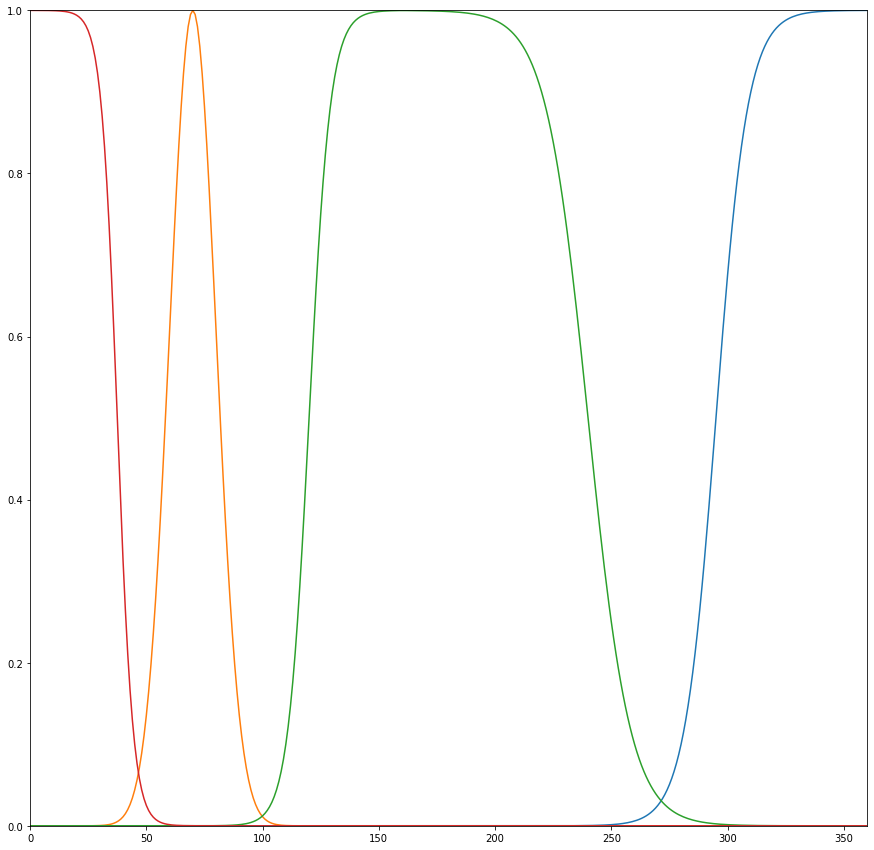

In [104]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

alpha.high_risk_left.plot()
alpha.medium_risk.plot()
alpha.low_risk.plot()
alpha.high_risk_right.plot()

ax.set_xlim(xmin=0, xmax=360)
ax.set_ylim(ymin=0, ymax=1)

fig.set_figwidth(15)
fig.set_figheight(15)

plt.show()
plt.close()

In [105]:
import numpy as np
# start = 0
# step = 0.5
# num = 20
# x_axis_for_s = start + np.arange(0, num) * step
# x_axis_for_s
x_axis_for_s = np.arange(start=50, stop=1000, step=50)
x_axis_for_s

array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750, 800, 850, 900, 950])

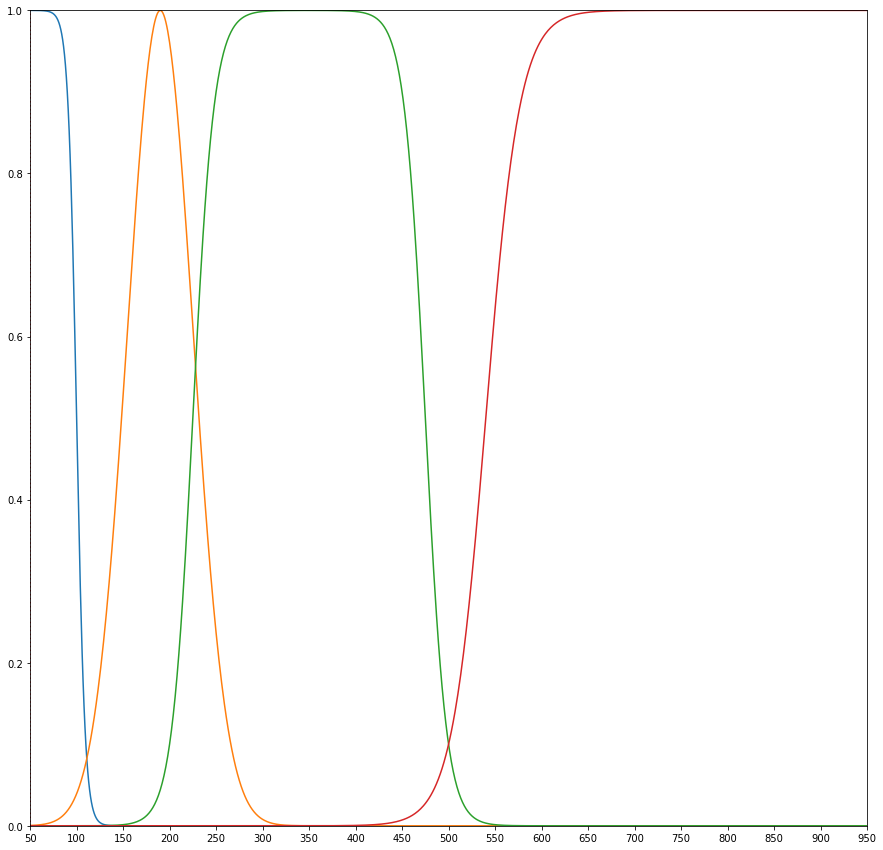

In [106]:
fig, ax = plt.subplots()

s.dangerously_close.plot() # синий
s.close.plot() # оранжевый
s.average.plot() # зелёный
s.far.plot() # красный

# чтобы было видно, где 0.5
plt.axvline(x=50, linestyle=':', color='r')

# ax.set_xticks(x_axis_for_s)
ax.set_xlim(xmin=50, xmax=950)
ax.set_ylim(ymin=0, ymax=1)

fig.set_figwidth(15)
fig.set_figheight(15)

plt.xticks(x_axis_for_s)
plt.show()
plt.close()

In [107]:
x_axis_for_v = np.arange(1005, step=50)
x_axis_for_v

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000])

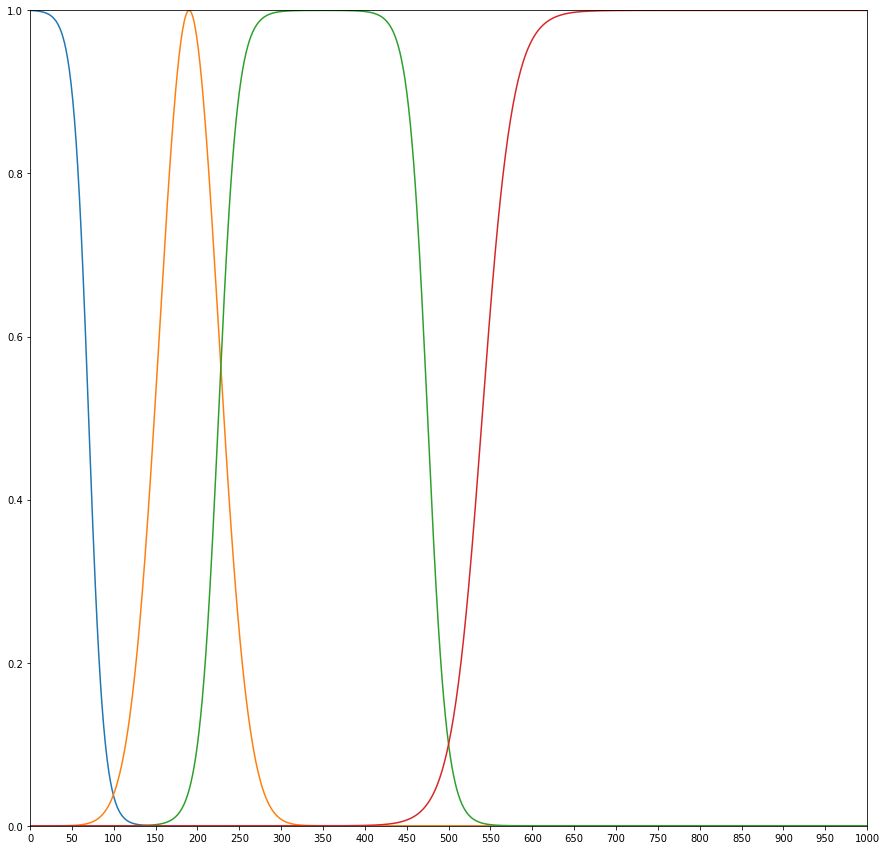

In [108]:
fig, ax = plt.subplots()

v.very_slow.plot() # синий
v.slow.plot() # оранжевый
v.moderate.plot() # зелёный
v.fast.plot() # красный

ax.set_xlim(xmin=0, xmax=950)
ax.set_ylim(ymin=0, ymax=1)

fig.set_figwidth(15)
fig.set_figheight(15)

plt.xticks(x_axis_for_v)
plt.show()
plt.close()

In [109]:
# выходы
# целевой угол (куда повернётся робот) (gamma) (градусы)
# # насколько я понимаю, целевой угол -- это не "НА СКОЛЬКО градусов надо повернуть колесо относительно текущего положения", а "какое должно быть новое положение колеса с
# # точки зрения угла"
# # # в таком случае нужно как-то прикинуть оценку, сколько времени поворот будет занимать (успеем ли)
# # # или забить?
# скорость робота (линейная) (v) (м/c)

In [237]:
# gamma
# категории: не поворачиваться, повернуться вправо ~на 45, повернуться влево ~на 45, повернуться влево ~на большой угол, повернуться вправо на ~большой угол
gamma = Domain("Angle turn", -180, 180)

gamma.do_not_turn = gauss(0, 0.1, c_m=1)

gamma.low_turn_to_right = gauss(45, 0.0005, c_m=1)

gamma.low_turn_to_left = gauss(-45, 0.0005, c_m=1)

gamma.high_turn_to_left = bounded_sigmoid(130, 140, inverse=False)
gamma.high_turn_to_left = gamma.high_turn_to_left.normalized()

gamma.high_turn_to_right = bounded_sigmoid(-140, -130, inverse=True)
gamma.high_turn_to_right = gamma.high_turn_to_right.normalized()

# new_v
# категории: остановиться, очень медленно, медленно, средне, быстро
new_v = Domain("New speed (cm/s)", 0, 1000)

new_v.stop = bounded_sigmoid(0, 5, inverse=True)
new_v.stop = new_v.stop.normalized()

new_v.very_slow = gauss(90, 0.001, c_m=1)

new_v.slow = gauss(190, 0.0004, c_m=1)

new_v.moderate_left = bounded_sigmoid(200, 250, inverse=False)
new_v.moderate_right = bounded_sigmoid(450, 500, inverse=True)
new_v.moderate = new_v.moderate_left & new_v.moderate_right

new_v.fast = bounded_sigmoid(500, 580, inverse=False)
new_v.fast = new_v.fast.normalized()

In [238]:
x_axis_for_gamma = np.arange(start=-180, stop=190, step=10)
x_axis_for_gamma

array([-180, -170, -160, -150, -140, -130, -120, -110, -100,  -90,  -80,
        -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,   20,   30,
         40,   50,   60,   70,   80,   90,  100,  110,  120,  130,  140,
        150,  160,  170,  180])

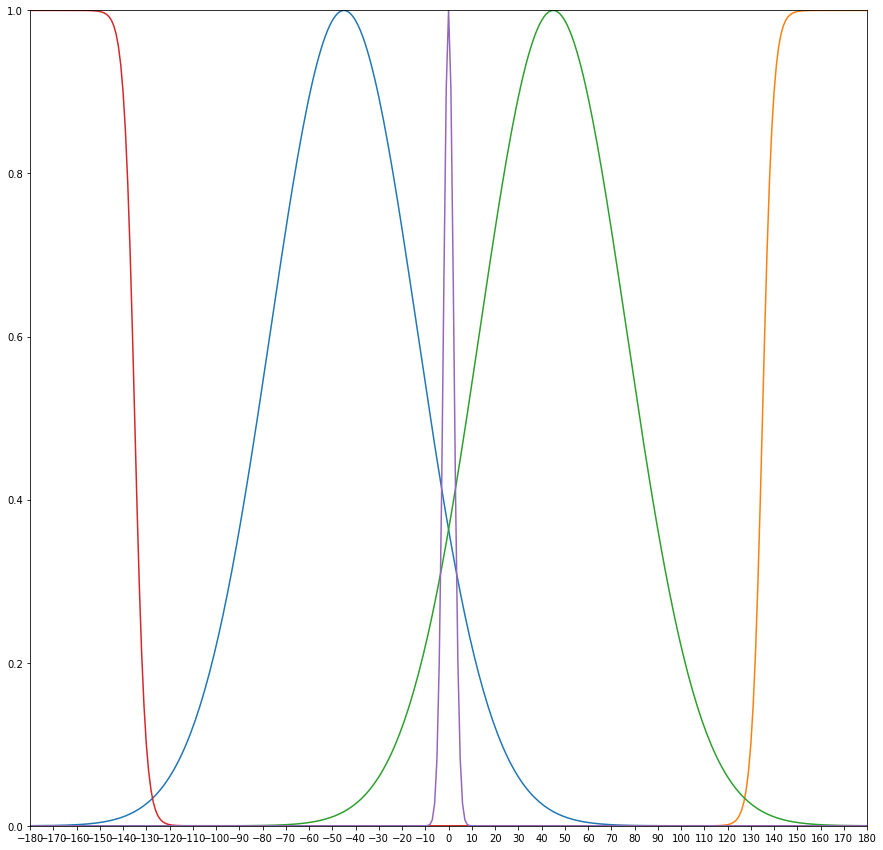

In [241]:
fig, ax = plt.subplots()

gamma.low_turn_to_left.plot() # синий
gamma.high_turn_to_left.plot() # оранжевый
gamma.low_turn_to_right.plot() # зелёный
gamma.high_turn_to_right.plot() # красный
gamma.do_not_turn.plot() # фиолетовый

ax.set_xlim(xmin=-180, xmax=180)
ax.set_ylim(ymin=0, ymax=1)

fig.set_figwidth(15)
fig.set_figheight(15)

plt.xticks(x_axis_for_gamma)
plt.show()
plt.close()

In [242]:
x_axis_for_new_v = np.arange(1005, step=50)
x_axis_for_new_v

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000])

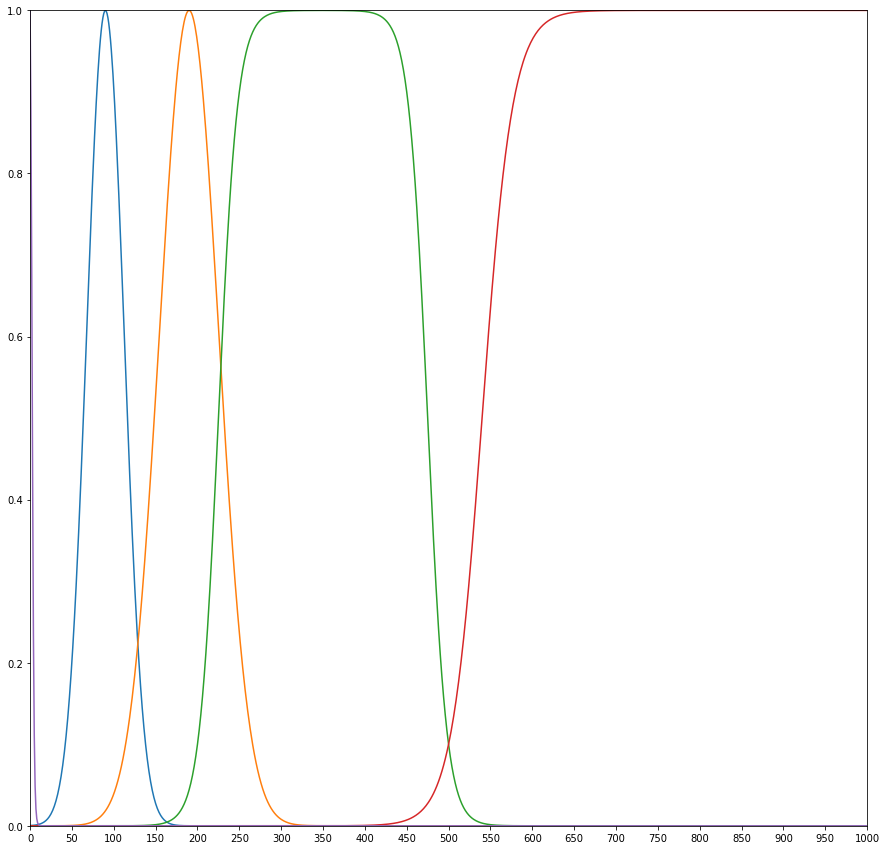

In [243]:
fig, ax = plt.subplots()

new_v.very_slow.plot() # синий
new_v.slow.plot() # оранжевый
new_v.moderate.plot() # зелёный
new_v.fast.plot() # красный
new_v.stop.plot() # фиолетовый

ax.set_xlim(xmin=0, xmax=950)
ax.set_ylim(ymin=0, ymax=1)

fig.set_figwidth(15)
fig.set_figheight(15)

plt.xticks(x_axis_for_new_v)
plt.show()
plt.close()

In [279]:
from fuzzylogic.classes import Rule

# препятствие слева, угол маленький
# расстояние опасно маленькое
# решение: (1) сбросить скорость как можно больше (2) практически не поворачиваться, оставаясь ~в нуле
g_R1 = Rule({(alpha.high_risk_left, s.dangerously_close, v.very_slow): gamma.do_not_turn})
g_R2 = Rule({(alpha.high_risk_left, s.dangerously_close, v.slow): gamma.do_not_turn})
g_R3 = Rule({(alpha.high_risk_left, s.dangerously_close, v.moderate): gamma.do_not_turn})
g_R4 = Rule({(alpha.high_risk_left, s.dangerously_close, v.fast): gamma.do_not_turn})

v_R1 = Rule({(alpha.high_risk_left, s.dangerously_close, v.very_slow): new_v.stop})
v_R2 = Rule({(alpha.high_risk_left, s.dangerously_close, v.slow): new_v.stop})
v_R3 = Rule({(alpha.high_risk_left, s.dangerously_close, v.moderate): new_v.stop})
v_R4 = Rule({(alpha.high_risk_left, s.dangerously_close, v.fast): new_v.stop})

# препятствие слева, угол маленьеий
# расстояние маленькое
# решение: (1) сделать поворот ~45 (чтобы успеть не врезаться) (2) понизить скорость (чтобы не превысило правую границу s)
g_R5 = Rule({(alpha.high_risk_left, s.close, v.very_slow): gamma.low_turn_to_right})
g_R6 = Rule({(alpha.high_risk_left, s.close, v.slow): gamma.low_turn_to_right})
g_R7 = Rule({(alpha.high_risk_left, s.close, v.moderate): gamma.low_turn_to_right})
g_R8 = Rule({(alpha.high_risk_left, s.close, v.fast): gamma.low_turn_to_right})

v_R5 = Rule({(alpha.high_risk_left, s.close, v.very_slow): new_v.very_slow})
v_R6 = Rule({(alpha.high_risk_left, s.close, v.slow): new_v.very_slow})
v_R7 = Rule({(alpha.high_risk_left, s.close, v.moderate): new_v.very_slow})
v_R8 = Rule({(alpha.high_risk_left, s.close, v.fast): new_v.very_slow})

# препятстсиве слева, угол маленький
# расстояние среднее
# решение: (1) сделать поворот ~45 (чтобы успеть не врезаться) (2) понизить скорость (чтобы не превысило правую границу s)
g_R9 = Rule({(alpha.high_risk_left, s.average, v.very_slow): gamma.low_turn_to_right})
g_R10 = Rule({(alpha.high_risk_left, s.average, v.slow): gamma.low_turn_to_right})
g_R11 = Rule({(alpha.high_risk_left, s.average, v.moderate): gamma.low_turn_to_right})
g_R12 = Rule({(alpha.high_risk_left, s.average, v.fast): gamma.low_turn_to_right})

v_R9 = Rule({(alpha.high_risk_left, s.average, v.very_slow): new_v.very_slow})
v_R10 = Rule({(alpha.high_risk_left, s.average, v.slow): new_v.very_slow})
v_R11 = Rule({(alpha.high_risk_left, s.average, v.moderate): new_v.slow})
v_R12 = Rule({(alpha.high_risk_left, s.average, v.fast): new_v.slow})

# препятствие слева, угол маленький
# расстояние большое
# решение: (1) сделать поворот ~90 (2) понизить скорость (чтобы не превысило правую границу s)
g_R13 = Rule({(alpha.high_risk_left, s.far, v.very_slow): gamma.high_turn_to_right})
g_R14 = Rule({(alpha.high_risk_left, s.far, v.slow): gamma.high_turn_to_right})
g_R15 = Rule({(alpha.high_risk_left, s.far, v.moderate): gamma.high_turn_to_right})
g_R16 = Rule({(alpha.high_risk_left, s.far, v.fast): gamma.high_turn_to_right})

v_R13 = Rule({(alpha.high_risk_left, s.far, v.very_slow): new_v.very_slow})
v_R14 = Rule({(alpha.high_risk_left, s.far, v.slow): new_v.slow})
v_R15 = Rule({(alpha.high_risk_left, s.far, v.moderate): new_v.moderate})
v_R16 = Rule({(alpha.high_risk_left, s.far, v.fast): new_v.moderate})


# угол средний
# расстояние очень маленькое
# решение: (1) не менять угол (2) не менять скорость
g_R17 = Rule({(alpha.medium_risk, s.dangerously_close, v.very_slow): gamma.do_not_turn})
g_R18 = Rule({(alpha.medium_risk, s.dangerously_close, v.slow): gamma.do_not_turn})
g_R19 = Rule({(alpha.medium_risk, s.dangerously_close, v.moderate): gamma.do_not_turn})
g_R20 = Rule({(alpha.medium_risk, s.dangerously_close, v.fast): gamma.do_not_turn})

v_R17 = Rule({(alpha.medium_risk, s.dangerously_close, v.very_slow): new_v.very_slow})
v_R18 = Rule({(alpha.medium_risk, s.dangerously_close, v.slow): new_v.slow})
v_R19 = Rule({(alpha.medium_risk, s.dangerously_close, v.moderate): new_v.moderate})
v_R20 = Rule({(alpha.medium_risk, s.dangerously_close, v.fast): new_v.fast})

# угол средний
# расстояние маленькое
# решение: (1) не менять угол (2) не менять скорость
g_R21 = Rule({(alpha.medium_risk, s.close, v.very_slow): gamma.do_not_turn})
g_R22 = Rule({(alpha.medium_risk, s.close, v.slow): gamma.do_not_turn})
g_R23 = Rule({(alpha.medium_risk, s.close, v.moderate): gamma.do_not_turn})
g_R24 = Rule({(alpha.medium_risk, s.close, v.fast): gamma.do_not_turn})

v_R21 = Rule({(alpha.medium_risk, s.close, v.very_slow): new_v.very_slow})
v_R22 = Rule({(alpha.medium_risk, s.close, v.slow): new_v.slow})
v_R23 = Rule({(alpha.medium_risk, s.close, v.moderate): new_v.moderate})
v_R24 = Rule({(alpha.medium_risk, s.close, v.fast): new_v.fast})

# угол средний
# расстояние среднее
# решение: (1) не менять угол (2) не менять скорость
g_R25 = Rule({(alpha.medium_risk, s.average, v.very_slow): gamma.do_not_turn})
g_R26 = Rule({(alpha.medium_risk, s.average, v.slow): gamma.do_not_turn})
g_R27 = Rule({(alpha.medium_risk, s.average, v.moderate): gamma.do_not_turn})
g_R28 = Rule({(alpha.medium_risk, s.average, v.fast): gamma.do_not_turn})

v_R25 = Rule({(alpha.medium_risk, s.average, v.very_slow): new_v.very_slow})
v_R26 = Rule({(alpha.medium_risk, s.average, v.slow): new_v.slow})
v_R27 = Rule({(alpha.medium_risk, s.average, v.moderate): new_v.moderate})
v_R28 = Rule({(alpha.medium_risk, s.average, v.fast): new_v.fast})

# угол средний
# расстояние большое
# решение: (1) не менять угол (2) не менять скорость
g_R29 = Rule({(alpha.medium_risk, s.far, v.very_slow): gamma.do_not_turn})
g_R30 = Rule({(alpha.medium_risk, s.far, v.slow): gamma.do_not_turn})
g_R31 = Rule({(alpha.medium_risk, s.far, v.moderate): gamma.do_not_turn})
g_R32 = Rule({(alpha.medium_risk, s.far, v.fast): gamma.do_not_turn})

v_R29 = Rule({(alpha.medium_risk, s.far, v.very_slow): new_v.very_slow})
v_R30 = Rule({(alpha.medium_risk, s.far, v.slow): new_v.slow})
v_R31 = Rule({(alpha.medium_risk, s.far, v.moderate): new_v.moderate})
v_R32 = Rule({(alpha.medium_risk, s.far, v.fast): new_v.fast})


# угол большой
# расстояние очень маленькое
# решение: (1) не менять угол (2) не менять скорость
g_R33 = Rule({(alpha.low_risk, s.dangerously_close, v.very_slow): gamma.do_not_turn})
g_R34 = Rule({(alpha.low_risk, s.dangerously_close, v.slow): gamma.do_not_turn})
g_R35 = Rule({(alpha.low_risk, s.dangerously_close, v.moderate): gamma.do_not_turn})
g_R36 = Rule({(alpha.low_risk, s.dangerously_close, v.fast): gamma.do_not_turn})

v_R33 = Rule({(alpha.low_risk, s.dangerously_close, v.very_slow): new_v.very_slow})
v_R34 = Rule({(alpha.low_risk, s.dangerously_close, v.slow): new_v.slow})
v_R35 = Rule({(alpha.low_risk, s.dangerously_close, v.moderate): new_v.moderate})
v_R36 = Rule({(alpha.low_risk, s.dangerously_close, v.fast): new_v.fast})

# угол большой
# расстояние маленькое
# решение: (1) не менять угол (2) не менять скорость
g_R37 = Rule({(alpha.low_risk, s.close, v.very_slow): gamma.do_not_turn})
g_R38 = Rule({(alpha.low_risk, s.close, v.slow): gamma.do_not_turn})
g_R39 = Rule({(alpha.low_risk, s.close, v.moderate): gamma.do_not_turn})
g_R40 = Rule({(alpha.low_risk, s.close, v.fast): gamma.do_not_turn})

v_R37 = Rule({(alpha.low_risk, s.close, v.very_slow): new_v.very_slow})
v_R38 = Rule({(alpha.low_risk, s.close, v.slow): new_v.slow})
v_R39 = Rule({(alpha.low_risk, s.close, v.moderate): new_v.moderate})
v_R40 = Rule({(alpha.low_risk, s.close, v.fast): new_v.fast})

# угол большой
# расстояние среднее
# решение: (1) не менять угол (2) не менять скорость
g_R41 = Rule({(alpha.low_risk, s.average, v.very_slow): gamma.do_not_turn})
g_R42 = Rule({(alpha.low_risk, s.average, v.slow): gamma.do_not_turn})
g_R43 = Rule({(alpha.low_risk, s.average, v.moderate): gamma.do_not_turn})
g_R44 = Rule({(alpha.low_risk, s.average, v.fast): gamma.do_not_turn})

v_R41 = Rule({(alpha.low_risk, s.average, v.very_slow): new_v.very_slow})
v_R42 = Rule({(alpha.low_risk, s.average, v.slow): new_v.slow})
v_R43 = Rule({(alpha.low_risk, s.average, v.moderate): new_v.moderate})
v_R44 = Rule({(alpha.low_risk, s.average, v.fast): new_v.fast})

# угол большой
# расстояние большое
# решение: (1) не менять угол (2) не менять скорость
g_R45 = Rule({(alpha.low_risk, s.far, v.very_slow): gamma.do_not_turn})
g_R46 = Rule({(alpha.low_risk, s.far, v.slow): gamma.do_not_turn})
g_R47 = Rule({(alpha.low_risk, s.far, v.moderate): gamma.do_not_turn})
g_R48 = Rule({(alpha.low_risk, s.far, v.fast): gamma.do_not_turn})

v_R45 = Rule({(alpha.low_risk, s.far, v.very_slow): new_v.very_slow})
v_R46 = Rule({(alpha.low_risk, s.far, v.slow): new_v.slow})
v_R47 = Rule({(alpha.low_risk, s.far, v.moderate): new_v.moderate})
v_R48 = Rule({(alpha.low_risk, s.far, v.fast): new_v.fast})


# препятствие справа, угол маленький
# расстояние опасно маленькое
# решение: (1) сбросить скорость как можно больше (2) практически не поворачиваться, оставаясь ~в нуле
g_R49 = Rule({(alpha.high_risk_right, s.dangerously_close, v.very_slow): gamma.do_not_turn})
g_R50 = Rule({(alpha.high_risk_right, s.dangerously_close, v.slow): gamma.do_not_turn})
g_R51 = Rule({(alpha.high_risk_right, s.dangerously_close, v.moderate): gamma.do_not_turn})
g_R52 = Rule({(alpha.high_risk_right, s.dangerously_close, v.fast): gamma.do_not_turn})

v_R49 = Rule({(alpha.high_risk_right, s.dangerously_close, v.very_slow): new_v.stop})
v_R50 = Rule({(alpha.high_risk_right, s.dangerously_close, v.slow): new_v.stop})
v_R51 = Rule({(alpha.high_risk_right, s.dangerously_close, v.moderate): new_v.stop})
v_R52 = Rule({(alpha.high_risk_right, s.dangerously_close, v.fast): new_v.stop})

# препятствие справа, угол маленьеий
# расстояние маленькое
# решение: (1) сделать поворот ~45 (чтобы успеть не врезаться) (2) понизить скорость (чтобы не превысило правую границу s)
g_R53 = Rule({(alpha.high_risk_right, s.close, v.very_slow): gamma.low_turn_to_left})
g_R54 = Rule({(alpha.high_risk_right, s.close, v.slow): gamma.low_turn_to_left})
g_R55 = Rule({(alpha.high_risk_right, s.close, v.moderate): gamma.low_turn_to_left})
g_R56 = Rule({(alpha.high_risk_right, s.close, v.fast): gamma.low_turn_to_left})

v_R53 = Rule({(alpha.high_risk_right, s.close, v.very_slow): new_v.very_slow})
v_R54 = Rule({(alpha.high_risk_right, s.close, v.slow): new_v.very_slow})
v_R55 = Rule({(alpha.high_risk_right, s.close, v.moderate): new_v.very_slow})
v_R56 = Rule({(alpha.high_risk_right, s.close, v.fast): new_v.very_slow})

# препятстсиве справа, угол маленький
# расстояние среднее
# решение: (1) сделать поворот ~45 (чтобы успеть не врезаться) (2) понизить скорость (чтобы не превысило правую границу s)
g_R57 = Rule({(alpha.high_risk_right, s.average, v.very_slow): gamma.low_turn_to_left})
g_R58 = Rule({(alpha.high_risk_right, s.average, v.slow): gamma.low_turn_to_left})
g_R59 = Rule({(alpha.high_risk_right, s.average, v.moderate): gamma.low_turn_to_left})
g_R60 = Rule({(alpha.high_risk_right, s.average, v.fast): gamma.low_turn_to_left})

v_R57 = Rule({(alpha.high_risk_right, s.average, v.very_slow): new_v.very_slow})
v_R58 = Rule({(alpha.high_risk_right, s.average, v.slow): new_v.very_slow})
v_R59 = Rule({(alpha.high_risk_right, s.average, v.moderate): new_v.slow})
v_R60 = Rule({(alpha.high_risk_right, s.average, v.fast): new_v.slow})

# препятствие справа, угол маленький
# расстояние большое
# решение: (1) сделать поворот ~90 (2) понизить скорость (чтобы не превысило правую границу s)
g_R61 = Rule({(alpha.high_risk_right, s.far, v.very_slow): gamma.high_turn_to_left})
g_R62 = Rule({(alpha.high_risk_right, s.far, v.slow): gamma.high_turn_to_right})
g_R63 = Rule({(alpha.high_risk_right, s.far, v.moderate): gamma.high_turn_to_left})
g_R64 = Rule({(alpha.high_risk_right, s.far, v.fast): gamma.high_turn_to_left})

v_R61 = Rule({(alpha.high_risk_right, s.far, v.very_slow): new_v.very_slow})
v_R62 = Rule({(alpha.high_risk_right, s.far, v.slow): new_v.slow})
v_R63 = Rule({(alpha.high_risk_right, s.far, v.moderate): new_v.moderate})
v_R64 = Rule({(alpha.high_risk_right, s.far, v.fast): new_v.moderate})

v_rules = sum([v_R1, v_R2, v_R3, v_R4, v_R5, v_R6, v_R7, v_R8, v_R9, 
               v_R10, v_R11, v_R12, v_R13, v_R14, v_R15, v_R16, v_R17, v_R18, v_R19, 
               v_R20, v_R21, v_R22, v_R23, v_R24, v_R25, v_R26, v_R27, v_R28, v_R29,
               v_R30, v_R31, v_R32, v_R33, v_R34, v_R35, v_R36, v_R37, v_R38, v_R39,
               v_R40, v_R41, v_R42, v_R43, v_R44, v_R45, v_R46, v_R47, v_R48, v_R49,
               v_R50, v_R51, v_R52, v_R53, v_R54, v_R55, v_R56, v_R57, v_R58, v_R59,
               v_R60, v_R61, v_R62, v_R63, v_R64])
g_rules = sum([g_R1, g_R2, g_R3, g_R4, g_R5, g_R6, g_R7, g_R8, g_R9, 
               g_R10, g_R11, g_R12, g_R13, g_R14, g_R15, g_R16, g_R17, g_R18, g_R19, 
               g_R20, g_R21, g_R22, g_R23, g_R24, g_R25, g_R26, g_R27, g_R28, g_R29,
               g_R30, g_R31, g_R32, g_R33, g_R34, g_R35, g_R36, g_R37, g_R38, g_R39,
               g_R40, g_R41, g_R42, g_R43, g_R44, g_R45, g_R46, g_R47, g_R48, g_R49,
               g_R50, g_R51, g_R52, g_R53, g_R54, g_R55, g_R56, g_R57, g_R58, g_R59,
               g_R60, g_R61, g_R62, g_R63, g_R64])

# вход: alpha, s, v
# выход: gamma, new_v

# препятствие слева, угол маленький
# расстояние опасно маленькое

# values = {alpha:10, s:75, v:50}
# v = 1.64, gamma = -0.5 

# values = {alpha:10, s:75, v:100}
# v = 12.13, gamma = -5.8

# values = {alpha:10, s:75, v:300}
# v = 2.52, gamma = -0.95 

# values = {alpha:10, s:75, v:700}
# v = 2.08, gamma = -0.72 


# препятствие слева, угол маленький
# расстояние маленькое

# values = {alpha:10, s:100, v:50}
# v = 8.12, gamma = -3.79 

# values = {alpha:10, s:100, v:100}
# v = 45.8, gamma = -22.94 

# values = {alpha:10, s:100, v:300}
# v = 9.13, gamma = -4.31 

# values = {alpha:10, s:100, v:700}
# v = 8.05, gamma = -3.76


# препятствие слева, угол маленький
# расстояние cреднее

# values = {alpha:10, s:300, v:50}
# v = 89.91, gamma = -45.37 

# values = {alpha:10, s:300, v:100}
# v = 89.94, gamma = -45.37 

# values = {alpha:10, s:300, v:300}
# v = 187.49, gamma = -45.37 

# values = {alpha:10, s:300, v:700}
# v = 189.03, gamma = -45.37 


# препятствие слева, угол маленький
# расстояние большое

# values = {alpha:10, s:700, v:50}
# v = 89.96, gamma = 156.49 

# values = {alpha:10, s:700, v:100}
# v = 142.2, gamma = -7.66

# values = {alpha:10, s:700, v:300}
# v = 348.39, gamma = 154.16

# values = {alpha:10, s:700, v:700}
# v = 349.65, gamma = 156.63


# угол средний
# расстояние опасно маленькое

# values = {alpha:75, s:75, v:50}
# v = , gamma = 

# values = {alpha:75, s:75, v:100}
# v = , gamma = 

# values = {alpha:75, s:75, v:300}
# v = , gamma = 

# values = {alpha:75, s:75, v:700}
# v = , gamma = 

# угол средний
# расстояние маленькое

# values = {alpha:75, s:100, v:50}
# v = , gamma = 

# values = {alpha:75, s:100, v:100}
# v = , gamma = 

# values = {alpha:75, s:100, v:300}
# v = , gamma = 

# values = {alpha:75, s:100, v:700}
# v = , gamma = 

# угол средний
# расстояние маленькое

# values = {alpha:75, s:100, v:50}
# v = , gamma = 

# values = {alpha:75, s:100, v:100}
# v = , gamma = 

# values = {alpha:75, s:100, v:300}
# v = , gamma = 

# values = {alpha:75, s:100, v:700}
# v = , gamma = 

values = {alpha:10, s:700, v:700}
v_rules(values)

349.6503563511032

In [280]:
# возможно, из этого следует, что сделать классы для s и v с одинаковыми по виду функциями распределения оказалась хорошей
g_rules(values)

156.6267954917896